In [7]:
from ipyparallel import Client
c = Client(profile='default')
dview = c[:]
lview = c.load_balanced_view()
lview.block = False

In [27]:
%%px --local

from IPython.display import display, clear_output
import sys
import numpy as np
import scipy as sp
import scipy.optimize as opt
import time
from psyFitLib import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

%matplotlib inline

In [3]:
%%px --local
nS = 5
nF = 5 

v0=0.3
speed=np.log(1+np.linspace(2,13,100)/v0)
speed5=np.log(1+np.array([3,4,5,6,7])/v0)
speed10=np.log(1+np.array([8,9,10,11,12])/v0)

freq = np.array([12.0, 16.0, 20.0, 24, 32, 40, 48])/25.6
freq2 = freq[0:5]
freq1 = freq[2:7]
# subject 1, 2, 3,...

case = 0

if case==0:
    # az decreasing sz increasing
    fileName = 'syn-glob-fit0'
    sz = 0.02+0.03*freq #0.01 + freq/30
    az = -2.5*freq#/freq
elif case==1:
    # az decreasing sz decreasing
    fileName = 'syn-glob-fit1'
    sz = 0.1-0.015*freq #0.01 + freq/30
    az = -4.5*freq#/freq
elif case==2:
    # az constant sz increasing 
    fileName = 'syn-glob-fit2'
    sz = 0.05+0.05*freq #0.01 + freq/30
    az = -3.5*freq/freq
elif case==3:
    # az decreasing sz constant
    fileName = 'syn-glob-fit3'
    sz = 0.08 * freq/freq #+0.05*freq #0.01 + freq/30
    az = -3.0*freq#/freq
    

mu1 =  +speed5[2]+az[2]*sz[2]-az[0:5]*sz[0:5] 
si1 = (sz[0:5] + sz[2])
mu2 =  +speed5[2]+az[4]*sz[4]-az[2:7]*sz[2:7] 
si2 =  (sz[2:7] + sz[5]) 

#print mu1
#print mu2

aa1, aa2, aa3, aa4 = [0.02 for i in range(4)]
bb1, bb2, bb3, bb4 = [0.02 for i in range(4)]

S5 = psyFun(np.array([speed5]).T,aa1,bb1,mu1,si1)
S5B = psyFun(np.array([speed5]).T,aa2,bb2,mu2,si2)


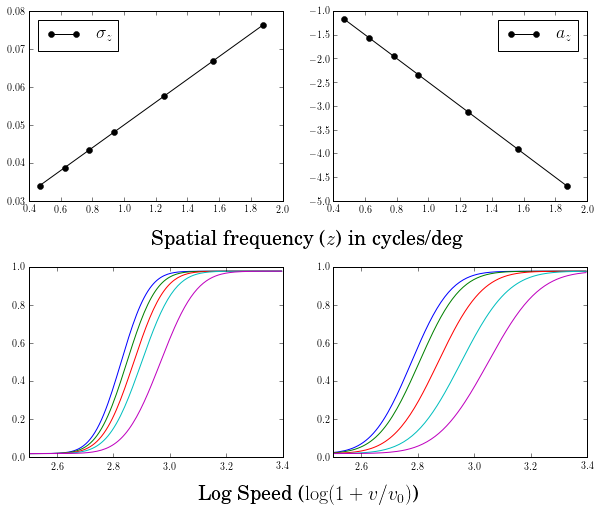

In [40]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2,figsize=(10, 8))
fig1.subplots_adjust(wspace=0.2, hspace=0.35)

spe = speed[(speed>2.5) & (speed<3.4)]
spe = spe[:,np.newaxis]
speedn = speed[:,np.newaxis]

axes1[0,0].plot(freq,sz, ls='-', marker='o', color='k', label='$\sigma_z$')
axes1[0,1].plot(freq,az, ls='-', marker='o', color='k', label='$a_z$')
axes1[1,0].plot(spe, psyFun(spe,aa1,bb1,mu1,si1));
axes1[1,1].plot(spe, psyFun(spe,aa2,bb2,mu2,si2));

axes1[0,0].set_xlabel(r'Spatial frequency ($z$) in cycles/deg', fontsize=20);
axes1[0,0].xaxis.set_label_coords(1.1, -0.15)

axes1[1,0].set_xlabel(r'Log Speed ($\log(1+v/v_0)$)', fontsize=20);
axes1[1,0].xaxis.set_label_coords(1.1, -0.15)

axes1[0,0].legend(fontsize=18, loc='best')
axes1[0,1].legend(fontsize=18, loc='best')

In [5]:
%%px --local
options={'ftol': 1e-8, 'disp': False, 'maxiter': 10000, 'maxfev': 100000}

# max number of experimental blocks
nBlock = 40

# set bounds to the initialization of variables (2 first are necessary, 2 last are large enough)
bnds = np.array([0.05, 0.05, 4.0, 1.0]) 

PsychFunc5 = np.zeros((nS,nF,nBlock))
PsychFunc5B = np.zeros((nS,nF,nBlock))

# generate synthetic data
for u in range(nBlock):
    PsychFunc5[:,:,u] = np.random.binomial(10,S5,(nS,nF))/10.0
    PsychFunc5B[:,:,u] = np.random.binomial(10,S5B,(nS,nF))/10.0

In [8]:
## Fitting 

# choose the number of blocks to test (<nBlock above)
#nBlocks = np.array([5, 10 ,20, 40])
nBlocks = np.array([5])

# stock fitted likelihood widths [7:14], prior slopes [0:7] and marginal errors here [10:12] 
xx = np.zeros((18, nBlocks.shape[0]))
az0 = np.zeros((7, nBlocks.shape[0]))
sz0 = np.zeros((7, nBlocks.shape[0]))
nb = 0
R0 = 2*48
R1 = 1*48

# measure time
t = time.time()

for nBlock in nBlocks:
    
    # send data on kernels
    dview.push(dict(PsychFunc5=PsychFunc5[:,:,:nBlock], PsychFunc5B=PsychFunc5B[:,:,:nBlock], nBlock=nBlock))
    
    # define obj fun on kernel
    %px objfun = build_objfun(PsychFunc5, PsychFunc5B, speed5, nBlock)
    
    # initialize results of step 1
    res1 = ()
    res0 = ()
    xx0 = np.zeros((4,nF))
    xx1 = np.zeros((4,nF))
    
    # compute initial condition
    for u in range(nF):
        # initialize objective functions of step 1 (indiv spat freq fitting)
        dview.push(dict(u=u))
        %px objfun0 = build_objfun0(PsychFunc5[:,u,:], speed5, nBlock)
        %px objfun1 = build_objfun0(PsychFunc5B[:,u,:], speed5, nBlock)
        
        # random init fitting using nelder-mead 
        # improvement is possible by computing the gradient but the problem is still non-convex
        def iter_init0(n):
            x0 = np.array([bnds[0]*np.random.rand(), bnds[1]*np.random.rand(),\
                           bnds[2]*(np.random.rand()-1), bnds[3]*np.random.rand()])
            res0 = opt.minimize(objfun0, x0, method='Nelder-Mead', options=options)
            return res0
        
        def iter_init1(n):
            x0 = np.array([bnds[0]*np.random.rand(), bnds[1]*np.random.rand(),\
                           bnds[2]*(np.random.rand()-1), bnds[3]*np.random.rand()])
            res1 = opt.minimize(objfun1, x0, method='Nelder-Mead', options=options)
            return res1
    
        # compute results in parallel (lview.map functions)           
        res0 = res0 + (lview.map(iter_init0, range(R0)),)
        res1 = res1 + (lview.map(iter_init1, range(R0)),)
    
    cond0 = np.array([res0[i].ready() for i in range(nF)]) 
    cond1 = np.array([res1[i].ready() for i in range(nF)])
    cond = cond0.prod()*cond1.prod()
    
    # wait for all parallel results 
    while not cond :
        time.sleep(1)
        clear_output(wait=True)
        p0 = np.array([np.float32(res0[i].progress) for i in range(nF)]).sum()
        p1 = np.array([np.float32(res1[i].progress) for i in range(nF)]).sum()
        print 'Blocks number:', nBlock, '\n Local opt.', '\n Progress:', (p0 + p1)/(2*nF*R0)*100, '%'
        sys.stdout.flush()
        cond0 = np.array([res0[i].ready() for i in range(nF)]) 
        cond1 = np.array([res1[i].ready() for i in range(nF)])
        cond = cond0.prod()*cond1.prod()
    
    # stock the result for the two condtions in xx0 and xx1  
    for u in range(nF): 
        fun0 = np.array([res0[u][i]['fun'] for i in range(R0) if res0[u][i]['success']==1 ]) 
        fun1 = np.array([res1[u][i]['fun'] for i in range(R0) if res1[u][i]['success']==1 ])
        
        xx0[:,u] = res0[u][np.int(fun0.argmin())]['x']
        xx1[:,u] = res1[u][np.int(fun1.argmin())]['x']
    
    # solve the linear system that link likelihood widths and prior slopes to threshold and differential PSE 
    az00, sz00 = initCond(xx0, xx1, 0*freq)
    
    # initialize step 2 
    x0 = np.zeros(18)
    x0[0:7] = az00
    x0[7:14] = np.abs(sz00)
    x0[14] = xx0[0,:].mean()
    x0[15] = xx0[1,:].mean()
    x0[16] = xx1[0,:].mean()
    x0[17] = xx1[1,:].mean()
    
    # sent initial condition to parallel kernels    
    dview.push(dict(x0=x0))
    
    # define random iteration fitting functions (random around the initial conditions above, empirical parameters)
    def iter_init(n):
        x00 = np.zeros(18)
        x00[0:7] = x0[0:7] + 0.5*(np.random.rand(7)-0.5)
        x00[7:14] = np.maximum(x0[7:14]+ 0.01*(np.random.rand(7)-0.5), 0.01*np.ones(7))# + (2*np.random.rand(7)-1)*x0[7:14]
        x00[14:18] = x0[14:18]
        res = opt.minimize(objfun, x00, method='Nelder-Mead',options=options)
        return res
    
    # run the computations in parallel    
    res = lview.map(iter_init, range(R1))
    
    # wait for parallel results
    while not res.ready():
            time.sleep(1)
            clear_output(wait=True)
            print 'Blocks number:', nBlock,'\n Global opt.', '\n Progress:', np.float32(res.progress)/R1*100, '%'
            sys.stdout.flush()   
    
    # keep the succesful fit    
    fun = np.array([res[i]['fun'] for i in range(R1) if res[i]['success']==1 ]) #if res0[i]['success']==1
    
    # stock the results of step 2 in xx
    xx[:,nb] = res[np.int(fun.argmin())]['x']
    # stock the results of step 1 in az0 and sz0
    az0[:,nb] = az00
    sz0[:,nb] = sz00
    nb += 1
        
elapsed = time.time() - t
print 'Time (s):', elapsed
    

Blocks number: 5 
 Global opt. 
 Progress: 100.0 %
Time (s): 200.291999817


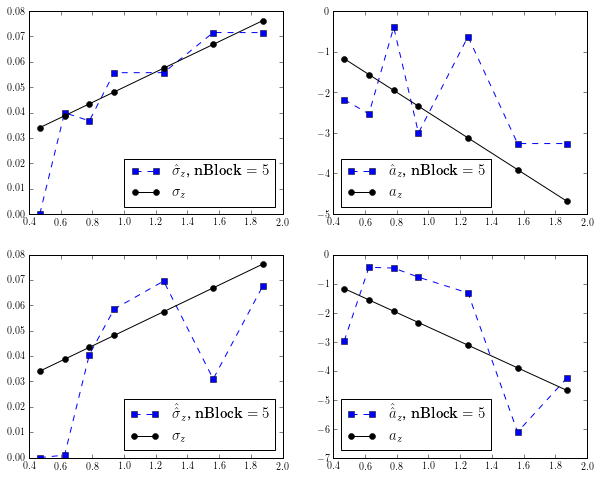

In [35]:
fig0, axes0 = plt.subplots(nrows=2, ncols=2,figsize=(10, 8))

m1 =  speed5[2]+xx[2]*xx[9]-xx[0:5]*xx[7:12] 
s1 = xx[7:12] + xx[9]
m2 =  speed5[2]+xx[4]*xx[11]-xx[2:7]*xx[9:14] 
s2 =  xx[9:14] + xx[11]

a1 = xx[14]
b1 = xx[15]
a2 = xx[16]
b2 = xx[17]

for i in range(nBlocks.shape[0]):
    axes0[1,0].plot(freq[0:7], xx[7:14,i], '--s', label='$\hat{\hat \sigma}_z$, $\mbox{nBlock} = %d$' %nBlocks[i]);
    axes0[1,1].plot(freq[0:7], xx[0:7,i], '--s', label='$\hat{\hat a}_z$, $\mbox{nBlock} = %d$' %nBlocks[i]);
    axes0[0,0].plot(freq[0:7], sz0[:,i], '--s', label='$\hat \sigma_z$, $\mbox{nBlock} = %d$' %nBlocks[i]);
    axes0[0,1].plot(freq[0:7], az0[:,i], '--s', label='$\hat a_z$, $\mbox{nBlock} = %d$' %nBlocks[i]);
    
axes0[0,0].plot(freq, sz, ls='-', marker='o', color='k', label='$\sigma_z$')    
axes0[0,1].plot(freq, az, ls='-', marker='o', color='k', label='$a_z$')  
axes0[1,0].plot(freq, sz, ls='-', marker='o', color='k', label='$\sigma_z$')    
axes0[1,1].plot(freq, az, ls='-', marker='o', color='k', label='$a_z$') 
axes0[0,0].legend(loc='best',fontsize=15.0);
axes0[0,1].legend(loc='best',fontsize=15.0);
axes0[1,0].legend(loc='best',fontsize=15.0);
axes0[1,1].legend(loc='best',fontsize=15.0);



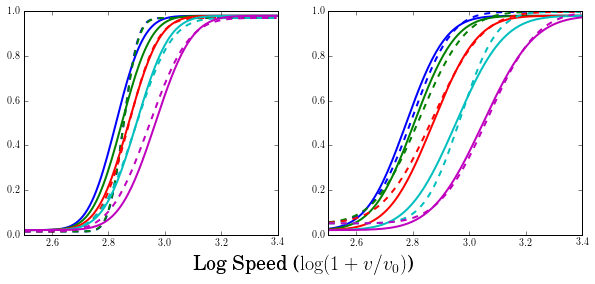

In [56]:
# check the fitted psychometric curves
fig1, axes1 = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
k = 0

from itertools import cycle
colors = ['b','g','r','c','m']
colorcycler1 = cycle(colors)
colorcycler2 = cycle(colors)
colorcycler3 = cycle(colors)
colorcycler4 = cycle(colors)

psyFunFitted1 = psyFun(spe, a1[k], b1[k], m1[:,k], s1[:,k])
psyFunFitted2 = psyFun(spe, a2[k], b2[k], m2[:,k], s2[:,k])
psyFun1 = psyFun(spe,aa1,bb1,mu1,si1)
psyFun2 = psyFun(spe,aa2,bb2,mu2,si2)

for i in range(5):
    axes1[0].plot(spe, psyFunFitted1[:,i], '--', lw=2, color=next(colorcycler1));
    axes1[1].plot(spe, psyFunFitted2[:,i], '--', lw=2, color=next(colorcycler2));
    axes1[0].plot(spe, psyFun1[:,i], lw=2, color=next(colorcycler3));
    axes1[1].plot(spe, psyFun2[:,i], lw=2, color=next(colorcycler4));
    
axes1[0].set_xlabel(r'Log Speed ($\log(1+v/v_0)$)', fontsize=20);
axes1[0].xaxis.set_label_coords(1.1, -0.1)


In [12]:
# store the fitted psychometric functions

S1 = ()
S2 = ()
for k in range(nBlocks.shape[0]):
    S1 = S1 + (psyFun(speed5[:,np.newaxis], a1[k], b1[k], m1[:,k], s1[:,k]),)
    S2 = S2 + (psyFun(speed5[:,np.newaxis], a2[k], b2[k], m2[:,k], s2[:,k]),)

(5, 4)

In [ ]:
# bootstrap 

# number of bootstrap repetitions
REP = 1000

# to store bootstrap results
xxBS = np.zeros((18, nBlocks.shape[0], REP))
az0BS = np.zeros((7, nBlocks.shape[0], REP))
sz0BS = np.zeros((7, nBlocks.shape[0], REP))

R0 = 2*48
R1 = 1*48

t = time.time()


for rep in range(REP):
    
    nb = 0
        
    for nBlock in nBlocks:
        
        # generate samples points from the fitted model S1/S2
        PsychFunc5 = np.zeros((nS,nF,nBlock))
        PsychFunc5B = np.zeros((nS,nF,nBlock))

        for u in range(nBlock):
            PsychFunc5[:,:,u] = np.random.binomial(10, S1[nb], (nS, nF))/10.0
            PsychFunc5B[:,:,u] = np.random.binomial(10, S2[nb], (nS, nF))/10.0
        
        # then the code is the same, see above
        dview.push(dict(PsychFunc5=PsychFunc5[:,:,:nBlock], PsychFunc5B=PsychFunc5B[:,:,:nBlock], nBlock=nBlock))

        %px objfun = build_objfun(PsychFunc5, PsychFunc5B, speed5, nBlock)

        res1 = ()
        res0 = ()
        xx0 = np.zeros((4,nF))
        xx1 = np.zeros((4,nF))

        # compute initial condition
        for u in range(nF):
            dview.push(dict(u=u))
            %px objfun0 = build_objfun0(PsychFunc5[:,u,:], speed5, nBlock)
            %px objfun1 = build_objfun0(PsychFunc5B[:,u,:], speed5, nBlock)

            def iter_init0(n):
                x0 = np.array([bnds[0]*np.random.rand(), bnds[1]*np.random.rand(),\
                               bnds[2]*(np.random.rand()-1), bnds[3]*np.random.rand()])
                res0 = opt.minimize(objfun0, x0, method='Nelder-Mead', options=options)
                return res0

            def iter_init1(n):
                x0 = np.array([bnds[0]*np.random.rand(), bnds[1]*np.random.rand(),\
                               bnds[2]*(np.random.rand()-1), bnds[3]*np.random.rand()])
                res1 = opt.minimize(objfun1, x0, method='Nelder-Mead', options=options)
                return res1


            res0 = res0 + (lview.map(iter_init0, range(R0)),)
            res1 = res1 + (lview.map(iter_init1, range(R0)),)
            
        cond0 = np.array([res0[i].ready() for i in range(nF)]) 
        cond1 = np.array([res1[i].ready() for i in range(nF)])
        cond = cond0.prod()*cond1.prod()
        
        while not cond :
            time.sleep(1)
            clear_output(wait=True)
            p0 = np.array([np.float32(res0[i].progress) for i in range(nF)]).sum()
            p1 = np.array([np.float32(res1[i].progress) for i in range(nF)]).sum()
            print 'Repetition:', rep+1 , '/', REP,  '\n Blocks number:', nBlock,\
            '\n Local opt.', '\n Progress: %.2f'%((p0 + p1)/(2*nF*R0)*100), '%',\
            '\n Time (h/m/s): %.2i'%((time.time() - t)//3600),':%.2i'%(((time.time() - t)//60)%60),\
            ':%.2i'%((time.time() - t)%60)
            sys.stdout.flush()
            cond0 = np.array([res0[i].ready() for i in range(nF)]) 
            cond1 = np.array([res1[i].ready() for i in range(nF)])
            cond = cond0.prod()*cond1.prod()

        for u in range(nF): 

            fun0 = np.array([res0[u][i]['fun'] for i in range(R0) if res0[u][i]['success']==1 ]) #if res0[i]['success']==1
            fun1 = np.array([res1[u][i]['fun'] for i in range(R0) if res1[u][i]['success']==1 ]) # if res1[i]['success']==1

            xx0[:,u] = res0[u][fun0.argmin()]['x']
            xx1[:,u] = res1[u][fun1.argmin()]['x']


        if subject==2:
            az00, sz00 = initCond(xx0, xx1, 0*freq)
        else:
            az00, sz00 = initCond(xx0, xx1, freq)

        x0 = np.zeros(18)
        x0[0:7] = az00
        x0[7:14] = np.abs(sz00)
        x0[14] = xx0[0,:].mean()
        x0[15] = xx0[1,:].mean()
        x0[16] = xx1[0,:].mean()
        x0[17] = xx1[1,:].mean()

        dview.push(dict(x0=x0))

        def iter_init(n):
            x00 = np.zeros(18)
            x00[0:7] = x0[0:7] + 0.5*(np.random.rand(7)-0.5)
            x00[7:14] = np.maximum(x0[7:14]+ 0.01*(np.random.rand(7)-0.5), 0.01*np.ones(7))# + (2*np.random.rand(7)-1)*x0[7:14]
            x00[14:18] = x0[14:18]
            res = opt.minimize(objfun, x00, method='Nelder-Mead',options=options)
            return res

        res = lview.map(iter_init, range(R1))

        while not res.ready():
                time.sleep(1)
                clear_output(wait=True)
                print 'Repetition:', rep+1 , '/', REP,  '\n Blocks number:', nBlock,\
                '\n Global opt.', '\n Progress: %.2f'%(np.float32(res.progress)/R1*100), '%',\
                '\n Time (h/m/s): %.2i'%((time.time() - t)//3600),':%.2i'%(((time.time() - t)//60)%60),\
                ':%.2i'%((time.time() - t)%60)
                sys.stdout.flush()   

        fun = np.array([res[i]['fun'] for i in range(R1) if res[i]['success']==1 ]) #if res0[i]['success']==1
        
        if not fun.size==0:
            xxBS[:,nb,rep] = res[fun.argmin()]['x']
        az0BS[:,nb,rep] = az00
        sz0BS[:,nb,rep] = sz00
        nb += 1

    
elapsed = time.time() - t

print 'Time (s):', elapsed
    

Repetition: 2 / 500 
 Blocks number: 5 
 Local opt. 
 Progress: 85.52 % 
 Time (h/m/s): 00 :02 :28


In [ ]:
fig5, axes5 = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))

for k in range(7):
    axes5[0,0].plot(xxBS[k,0,:])
    axes5[0,1].plot(xxBS[k,1,:])
    axes5[0,2].plot(xxBS[k,2,:])
    axes5[0,3].plot(xxBS[k,3,:])
    axes5[1,0].plot(xxBS[7+k,0,:])
    axes5[1,1].plot(xxBS[7+k,1,:])
    axes5[1,2].plot(xxBS[7+k,2,:])
    axes5[1,3].plot(xxBS[7+k,3,:])

In [ ]:
fig6, axes6 = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))

for k in range(7):
    axes6[0,0].plot(az0BS[k,0,:])
    axes6[0,1].plot(az0BS[k,1,:])
    axes6[0,2].plot(az0BS[k,2,:])
    axes6[0,3].plot(az0BS[k,3,:])
    axes6[1,0].plot(sz0BS[k,0,:])
    axes6[1,1].plot(sz0BS[k,1,:])
    axes6[1,2].plot(sz0BS[k,2,:])
    axes6[1,3].plot(sz0BS[k,3,:])

In [ ]:
# compute error bar and save data

xxBS.sort(axis=2)
az0BS.sort(axis=2)
sz0BS.sort(axis=2)

# remove abused values due to algorithm fails (check the fig above)
e = 1

ERRxx = xxBS[:,:,e:REP-e].std(axis=2)
ERRsz0 = sz0BS[:,:,e:REP-e].std(axis=2)
ERRaz0 = az0BS[:,:,e:REP-e].std(axis=2)

xx = xxBS[:,:,e:REP-e].mean(axis=2)
sz0 = sz0BS[:,:,e:REP-e].mean(axis=2)
az0 = az0BS[:,:,e:REP-e].mean(axis=2)

np.savez(fileName, xx=xx, az0=az0, sz0=sz0, ERRxx=ERRxx, ERRaz0=ERRaz0, ERRsz0=ERRsz0, az=az, sz=sz)    
